In [1]:
import sys
import os
from pathlib import Path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)
from data.data_loader import DataLoader
import data.indicators as Indicators
import numpy as np
import pandas as pd

parent_dir = Path().resolve().parent
models_dir = parent_dir / "models"
models_dir.mkdir(parents=True, exist_ok=True)

dfmain = DataLoader.load_data()
df = dfmain.copy()

In [8]:
def generate_perfect_signals(df, lookahead):
    df = df.copy()
    df['signals'] = np.nan  # Initialize with NaN for proper trend marking

    for i in range(len(df) - lookahead):
        future_prices = df['close'].iloc[i+1 : i+1+lookahead].values
        if len(future_prices) > 0:
            max_future_price = np.max(future_prices)
            min_future_price = np.min(future_prices)

            # If the price is near the lowest future price, mark an uptrend (1)
            if df['close'].iloc[i] <= min_future_price + 0.1:
                df.at[i, 'signals'] = 1  # Uptrend

            # If the price is near the highest future price, mark a downtrend (0)
            elif df['close'].iloc[i] >= max_future_price - 0.1:
                df.at[i, 'signals'] = 0  # Downtrend

    # **Propagate the trend signals forward**
    df['signals'] = df['signals'].ffill().fillna(0)  # Fill NaN values with previous trend, default to 0
    
    return df

df = generate_perfect_signals(dfmain,20)

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np

def preprocess_data(df, window_size=60):
    """Prepare dataset for deep learning models."""
    
    # Drop missing values created by rolling window calculations
    df.dropna(inplace=True)

    # Exclude datetime columns
    df = df.select_dtypes(include=[np.number])  # Keep only numeric columns
    
    # Define MinMax and Standard scaling columns
    min_max_cols = ["RSI", "slowk", "slowd", "ADX", "Close_Relative"]
    standard_cols = list(set(df.columns) - set(min_max_cols))

    min_max_scaler = MinMaxScaler()
    standard_scaler = StandardScaler()

    # Apply scaling only if the columns exist
    if set(min_max_cols).issubset(df.columns):
        df[min_max_cols] = min_max_scaler.fit_transform(df[min_max_cols])
    
    if set(standard_cols).issubset(df.columns):
        df[standard_cols] = standard_scaler.fit_transform(df[standard_cols])

    print("Min-Max Scaled features:", min_max_cols)
    print("Standard Scaled features:", standard_cols)

    # Convert into time-series sequences (shape: [samples, timesteps, features])
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df.iloc[i:i+window_size].values)  # Last N timesteps
        y.append(df["signals"].iloc[i+window_size])  # Target trend (0 or 1)

    return np.array(X), np.array(y), min_max_scaler, standard_scaler

X, Y, MMS, SS = preprocess_data(df, window_size=60)


Min-Max Scaled features: ['RSI', 'slowk', 'slowd', 'ADX', 'Close_Relative']
Standard Scaled features: ['open', 'shares', 'Log_Returns', 'MACD_hist', 'BB_middle', 'ATR', 'DC_middle', 'MACD', 'OBV', 'Sharpe_Ratio', 'DC_upper', 'Ichimoku_Kijun', 'Unnamed: 0', 'EMA_fast', 'Parabolic_SAR', 'low', 'Ichimoku_Senkou_A', 'EMA_slow', 'Ichimoku_Tenkan', 'close', 'Cumulative_Returns', 'MACD_signal', 'BB_upper', 'portfolio_value', 'ROC', 'CMF', 'DC_lower', 'BB_lower', 'Drawdown', 'high', 'Volume_SMA', 'volume', 'Ichimoku_Senkou_B', 'signals', 'Volatility', 'Norm_ATR', 'Volume_Threshold', 'Ulcer_Index']


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Select features and target
features = ["EMA_slow", "EMA_fast", "RSI", "BB_upper", "BB_middle", "BB_lower",
            "ATR", "MACD", "MACD_signal", "MACD_hist", "slowk", "slowd",
            "ROC", "ADX", "DC_upper", "DC_lower", "DC_middle", "Volume_SMA",
            "Volume_Threshold", "Volatility"]  # Add more if needed

target = "signals"

# Drop NaN values (if any)
df = df.dropna()

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Convert to NumPy arrays
X, y = np.array(X_scaled), np.array(df[target])

# Reshape X for LSTM (samples, timesteps, features)
timesteps = 10  # Number of past periods to consider
X_lstm = []
y_lstm = []

for i in range(len(X) - timesteps):
    X_lstm.append(X[i:i+timesteps])  # Take `timesteps` periods of data
    y_lstm.append(y[i+timesteps])  # Target at `t+timesteps`

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.1, random_state=42)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")


Training Data Shape: (386517, 10, 20)
Testing Data Shape: (42947, 10, 20)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_lstm_model(input_shape):
    """Create an LSTM model for trend classification."""
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),  # First LSTM layer
        Dropout(0.2),  # Regularization
        LSTM(32, return_sequences=False),  # Second LSTM layer
        Dropout(0.2),
        Dense(16, activation="relu"),  # Fully connected layer
        Dense(1, activation="sigmoid")  # Output layer (0 or 1)
    ])
    
    # Compile model
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model
# Build the model
model = build_lstm_model(input_shape=(timesteps, len(features)))

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

# Save the model for future use

model_path = models_dir / "LSTM_model.h5"
model.save(str(model_path))


Epoch 1/100
12079/12079 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - accuracy: 0.6184 - loss: 0.6551 - val_accuracy: 0.6352 - val_loss: 0.6431
Epoch 2/100
12079/12079 ━━━━━━━━━━━━━━━━━━━━ 70s 6ms/step - accuracy: 0.6382 - loss: 0.6426 - val_accuracy: 0.6435 - val_loss: 0.6371
Epoch 3/100
12079/12079 ━━━━━━━━━━━━━━━━━━━━ 72s 6ms/step - accuracy: 0.6412 - loss: 0.6390 - val_accuracy: 0.6469 - val_loss: 0.6351
Epoch 4/100
12079/12079 ━━━━━━━━━━━━━━━━━━━━ 73s 6ms/step - accuracy: 0.6451 - loss: 0.6353 - val_accuracy: 0.6481 - val_loss: 0.6323
Epoch 5/100
12079/12079 ━━━━━━━━━━━━━━━━━━━━ 71s 6ms/step - accuracy: 0.6488 - loss: 0.6324 - val_accuracy: 0.6531 - val_loss: 0.6292
Epoch 6/100
12079/12079 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6529 - loss: 0.6289

KeyboardInterrupt: 

1343/1343 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 1.0000 - loss: 6.4371e-12
Test Accuracy: 1.0000


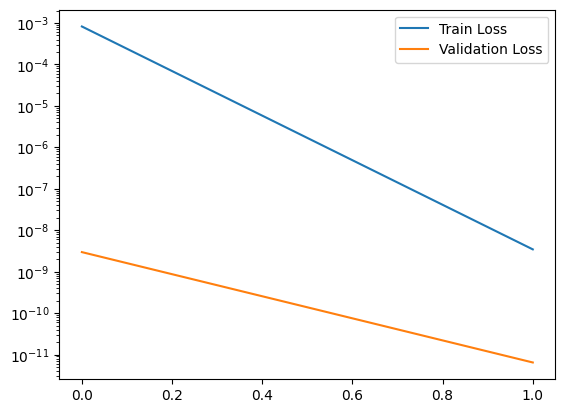

In [10]:
import matplotlib.pyplot as plt

# Evaluate on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Plot training history
plt.semilogy(history.history["loss"], label="Train Loss")
plt.semilogy(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()


### Hyper tuning

In [34]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_optimized_lstm(input_shape, learning_rate=0.001, lstm_units=64, dropout_rate=0.2):
    """Builds an optimized LSTM model."""
    model = Sequential([
        LSTM(units=lstm_units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(units=lstm_units),
        Dropout(dropout_rate),
        Dense(units=1, activation="sigmoid")  # Binary classification
    ])
    
    model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=learning_rate), metrics=["accuracy"])
    return model

# Try different parameters
optimized_model = build_optimized_lstm(input_shape=(timesteps, len(features)), learning_rate=0.0005, lstm_units=128, dropout_rate=0.3)

# Train the new model
history_opt = optimized_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stop])


Epoch 1/50


e:\Python\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9445 - loss: 0.2738 - val_accuracy: 1.0000 - val_loss: 1.4372e-04
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 1.0000 - loss: 1.5099e-04 - val_accuracy: 1.0000 - val_loss: 6.7723e-05
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 1.0000 - loss: 7.5526e-05 - val_accuracy: 1.0000 - val_loss: 3.9302e-05
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 1.0000 - loss: 4.4657e-05 - val_accuracy: 1.0000 - val_loss: 2.5653e-05
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 1.0000 - loss: 2.9754e-05 - val_accuracy: 1.0000 - val_loss: 1.8303e-05
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 1.0000 - loss: 2.3043e-05 - val_accuracy: 1.0000 - val_loss: 1.3676e-05
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 1.0000 - loss: 1.7075e-05 - val_accuracy: 1.0000 - val_loss: 1.0786e-05
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 1.0000 

In [12]:
import pandas as pd
# Make predictions
y_pred_prob = optimized_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to 0/1 labels

# Compare actual vs predicted
df_test = pd.DataFrame({"Actual": y_test, "Predicted": y_pred.flatten()})
print(df_test.head(200))


NameError: name 'optimized_model' is not defined

In [38]:
from sklearn.metrics import classification_report

# Print performance metrics
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1239

    accuracy                           1.00      1239
   macro avg       1.00      1.00      1.00      1239
weighted avg       1.00      1.00      1.00      1239

